# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблями из самых популярных библиотек.

In [32]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
from collections import Counter
import math
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
def gini(x):
    tar_count = Counter(x)
    G = 0
    len_x = len(x)
    for c in tar_count.values():
        G += (c/len_x)*(1-c/len_x)
    return G
        
    
def entropy(x):
    tar_count = Counter(x)
    E = 0
    len_x = len(x)
    for c in tar_count.values():
        E += (c/len_x)*(math.log2(c/len_x))
    return E

def gain(left_y, right_y, criterion):
    tars = list(left_y) + list(right_y)
    old = criterion(tars)
    new = (len(left_y)*criterion(left_y)+len(right_y)*criterion(right_y))/len(tars)
    return old-new

In [3]:
class DecisionTreeClassifier:
    def __init__(self, criterion='gini', max_depth=None, min_samples_leaf=1):
        self.root = None
        self.depth = 1
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
    
    
    def test_split(self, feat, value, X):
        left, right = [], []
        for row in X:
            if row[feat] < value:
                left.append(row)
            else:
                right.append(row)
        return np.asarray(left), np.asarray(right)

    def get_split(self, X):
        best_feat, best_value, best_gain, best_left, best_right = None, None, -float('inf'), None, None
        for feat in range(X.shape[1]-1):
            for row in X:
                left, right = self.test_split(feat, row[feat], X)
                if len(left) == 0 or len(right) == 0:
                    continue
                gain_cur = gain(left[:,-1], right[:,-1], gini if self.criterion == 'gini' else entropy)
                if gain_cur > best_gain:
                    best_feat, best_value, best_gain, best_left, best_right = feat, row[feat], gain_cur, left, right
        if best_feat == None:
            return {'feat': feat, 'value': row[feat], 'left': left, 'right': right}
        else:
            return {'feat': best_feat, 'value': best_value, 'left': best_left, 'right': best_right}
    
    def probs(self, subset, var):
        labels = [row[-1] for row in subset]
        if var == 1:
            return [[0, labels.count(0)/len(subset)],
                   [1, labels.count(1)/len(subset)]]
        else:
            return [[0, labels.count(1)/len(subset)],
                   [1, labels.count(0)/len(subset)]]
        
    
    def get_tree(self, node, depth):
        if len(node['left']) == 0:
            node['left'] = self.probs(node['right'], 0)
            node['right'] = self.probs(node['right'], 1)
            return
        elif len(node['right']) == 0:
            node['right'] = self.probs(node['left'], 0)
            node['left'] = self.probs(node['left'], 1)
            return    
        if depth == self.max_depth:
            node['left'] = self.probs(node['left'], 1)
            node['right'] = self.probs(node['right'], 1)
            return
        if len(node['left']) <= self.min_samples_leaf:
            node['left'] = self.probs(node['left'], 1)
        else:
            if list(node['left'][:,-1]).count(1) == 0 or list(node['left'][:,-1]).count(0) == 0:
                node['left'] = self.probs(node['left'], 1)
            else:
                node['left'] = self.get_split(node['left'])
                self.get_tree(node['left'], depth+1)
        if len(node['right']) <= self.min_samples_leaf:
            node['right'] = self.probs(node['right'], 1)
        else:
            if list(node['right'][:,-1]).count(1) == 0 or list(node['right'][:,-1]).count(0) == 0:
                node['right'] = self.probs(node['right'], 1)
            else:
                node['right'] = self.get_split(node['right'])
                self.get_tree(node['right'], depth+1)
    
    
    def fit(self, X):
        root = self.get_split(X)
        self.get_tree(root, self.depth)
        return root
        
    def print_tree(self, node, depth=0):
        if isinstance(node, dict):
            print('%s[X%d < %.3f]' % ((depth*' ', (node['feat']+1), node['value'])))
            self.print_tree(node['left'], depth+1)
            self.print_tree(node['right'], depth+1)
        else:
            print('%s[%s]' % ((depth*' ', node)))
        
                
        
    
    def predict_proba(self, X, root):
        proba = []
        for row in X:
            node = root
            while isinstance(node, dict):
                if row[node['feat']] < node['value']:
                    node = node['left']
                else:
                    node = node['right']
            proba.append({node[0][0]: node[0][1],
                          node[1][0]: node[1][1]})
        return proba
            
                
    
    def predict(self, X, root):
        proba = self.predict_proba(X, root)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

In [4]:
def read_cancer_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    y = [1 if i == 'M' else 0 for i in df['label']]
    return np.asarray(df.drop("label", axis=1)), np.asarray(y)

def read_spam_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv, header=0)
    y = df["label"]
    return np.asarray(df.drop("label", axis=1)), np.asarray(y.values)

In [5]:
Cancer_path = 'cancer.csv'
Spam_path = 'spam.csv'

In [100]:
X_cancer, y_cancer = read_cancer_dataset(Cancer_path)
X_spam, y_spam = read_spam_dataset(Spam_path)

In [101]:
Spam = np.concatenate([X_spam, y_spam[:,None]], axis=1)

### Задание 1 (3 балла)
Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание. Используйте реализацию дерева из HW3.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

In [117]:
class RandomForestClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1, max_features="auto", n_estimators=10):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.n_estimators = n_estimators
        self.trees = []

    
    def fit(self, X):
        for _ in range(self.n_estimators):
            print(_)
            tree = DecisionTreeClassifier(self.criterion, self.max_depth, self.min_samples_leaf)
            X_train  = np.concatenate((train_test_split(X, train_size = 0.05)[0], train_test_split(X, train_size = 0.05)[0]), axis=0)
            self.trees.append([tree, tree.fit(X_train)])
            
        
    
    def predict(self, X):
        predictions = []
        for i in range(self.n_estimators):
            predictions.append(self.trees[i][0].predict(X, self.trees[i][1]))
        y_pred = np.array([np.bincount(np.asarray(predictions)[:,i]).argmax() for i in range(len(predictions[0]))])
        return y_pred
        
    def predict_proba(self , X):
        predictions = []
        for i in range(self.n_estimators):
            predictions.append(self.trees[i][0].predict(X, self.trees[i][1]))
        return [{0:np.count_nonzero(np.asarray(predictions)[:,i] == 0)/len(np.asarray(predictions)[:,i]),
                 1:np.count_nonzero(np.asarray(predictions)[:,i] == 1)/len(np.asarray(predictions)[:,i])} for i in range(len(predictions[0]))]        

In [124]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

In [118]:
tree = RandomForestClassifier(max_depth=5, min_samples_leaf=30, n_estimators=3)

In [119]:
tree.fit(Spam)

0
1
2


In [121]:
y_pred = tree.predict(Spam)

In [123]:
tree.predict_proba(Spam)

[{0: 0.0, 1: 1.0},
 {0: 0.0, 1: 1.0},
 {0: 0.0, 1: 1.0},
 {0: 0.0, 1: 1.0},
 {0: 0.0, 1: 1.0},
 {0: 0.3333333333333333, 1: 0.6666666666666666},
 {0: 1.0, 1: 0.0},
 {0: 0.3333333333333333, 1: 0.6666666666666666},
 {0: 0.0, 1: 1.0},
 {0: 0.0, 1: 1.0},
 {0: 0.6666666666666666, 1: 0.3333333333333333},
 {0: 0.3333333333333333, 1: 0.6666666666666666},
 {0: 0.0, 1: 1.0},
 {0: 0.0, 1: 1.0},
 {0: 0.3333333333333333, 1: 0.6666666666666666},
 {0: 0.0, 1: 1.0},
 {0: 0.3333333333333333, 1: 0.6666666666666666},
 {0: 0.0, 1: 1.0},
 {0: 1.0, 1: 0.0},
 {0: 0.3333333333333333, 1: 0.6666666666666666},
 {0: 0.3333333333333333, 1: 0.6666666666666666},
 {0: 0.0, 1: 1.0},
 {0: 0.3333333333333333, 1: 0.6666666666666666},
 {0: 0.3333333333333333, 1: 0.6666666666666666},
 {0: 0.0, 1: 1.0},
 {0: 0.0, 1: 1.0},
 {0: 0.0, 1: 1.0},
 {0: 0.3333333333333333, 1: 0.6666666666666666},
 {0: 0.6666666666666666, 1: 0.3333333333333333},
 {0: 0.0, 1: 1.0},
 {0: 0.3333333333333333, 1: 0.6666666666666666},
 {0: 0.33333333333333

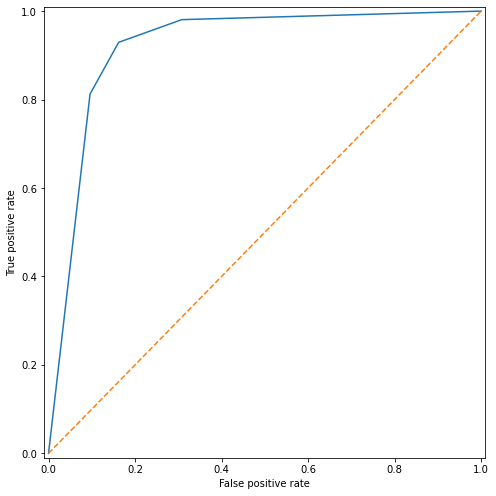

In [125]:
plot_roc_curve(Spam[:,-1], tree.predict_proba(Spam))

### Задание 3 (2 балла)
Оптимизируйте по `AUC` на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации `Random Forest`: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте `ROC` кривую (и выведите `AUC` и `accuracy`) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [ ]:
# YOUR_CODE

### Задание 4 (3 балла)
Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [ ]:
def feature_importance(rfc):
    raise NotImplementedError()

def most_important_features(importance, names, k=20):
    # Выводит названия k самых важных признаков
    idicies = np.argsort(importance)[::-1][:k]
    return np.array(names)[idicies]

Протестируйте решение на простом синтетическом наборе данных. В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [ ]:
def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return np.array(X), np.array(y)

X, y = synthetic_dataset(1000)
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X, y)
print("Accuracy:", np.mean(rfc.predict(X) == y))
print("Importance:", feature_importance(rfc))

Проверьте, какие признаки важны для датасетов cancer и spam?

_Ваш ответ_

### Задание 5 (2 балла)
В качестве альтернативы попробуем библиотечные реализации ансамблей моделей. 

1. [CatBoost](https://catboost.ai/docs/)
2. [XGBoost](https://xgboost.readthedocs.io/en/latest/)
3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/)


Установите необходимые библиотеки. 
Возможно, потребуется установка дополнительных пакетов

In [ ]:
!pip install lightgbm
!pip install catboost
!pip install xgboost

Также, как и реализованный нами RandomForest, примените модели для наших датасетов.

Для стандартного набора параметров у каждой модели нарисуйте `ROC` кривую и выведите `AUC` и `accuracy`.

Посчитайте время обучения каждой модели (можно использовать [timeit magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)). 

Сравните метрики качества и скорость обучения моделей. Какие выводы можно сделать?

In [1]:
# YOUR_CODE

_Ваш ответ_